### 聚类并可视化

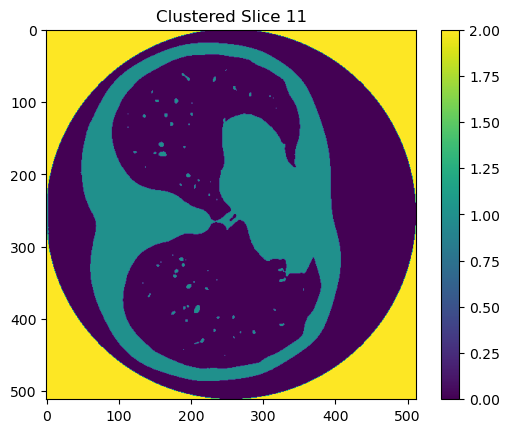

In [11]:
import numpy as np
import nibabel as nib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 加载NII数据
nii_data = nib.load('Data/study_001.nii')
ct_data = nii_data.get_fdata()

# 分割每个CT层
num_slices = ct_data.shape[2]

# 对每个CT层进行亮度聚类
num_clusters = 3  # 你可以根据需要调整聚类簇的数量

# for i in range(num_slices):
# 获取当前层数据
i = 10
slice_data = ct_data[:, :, i]

# 标准化数据
normalized_slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

# 将二维数据转换为一维
flattened_slice_data = normalized_slice_data.flatten()

# 应用K均值聚类
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=0)
kmeans.fit(flattened_slice_data.reshape(-1, 1))

# 获取聚类标签
labels = kmeans.labels_

# 将聚类标签重塑回二维形状
clustered_slice_data = labels.reshape(normalized_slice_data.shape)

# 可视化聚类结果
plt.imshow(clustered_slice_data, cmap='viridis')
plt.colorbar()
plt.title('Clustered Slice {}'.format(i+1))
plt.show()



### 查看索引标签

In [12]:
# 查看聚类簇的索引范围
min_index = np.min(labels)
max_index = np.max(labels)
print("Cluster index range:", min_index, "to", max_index)

# 查看唯一的聚类标签
unique_labels = np.unique(labels)
print("Unique cluster labels:", unique_labels)


Cluster index range: 0 to 2
Unique cluster labels: [0 1 2]


### 获取特殊范围

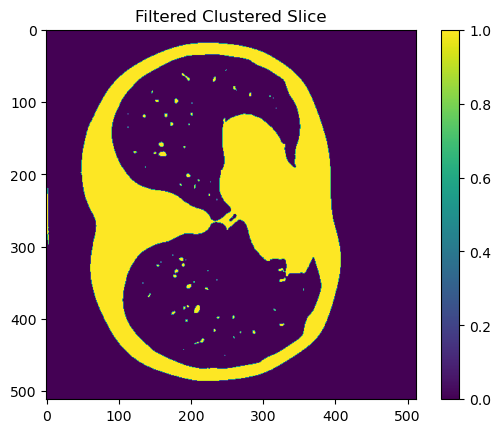

In [13]:
# 过滤标签不为1的像素
filtered_slice_data = np.where(clustered_slice_data == 2, 0, clustered_slice_data)

# 可视化过滤后的结果
plt.imshow(filtered_slice_data, cmap='viridis')
plt.colorbar()
plt.title('Filtered Clustered Slice')
plt.show()


### 获取次亮区域范围

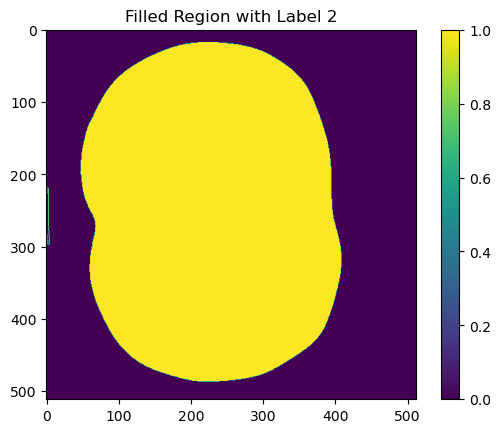

In [14]:
from skimage.segmentation import find_boundaries
from scipy.ndimage import binary_fill_holes

# 找到标签为2的区域边界
boundaries = find_boundaries(filtered_slice_data, mode='outer')

# 将边界内的所有区域填充
filled_image = binary_fill_holes(boundaries)

# 可视化结果
plt.imshow(filled_image, cmap='viridis')
plt.colorbar()
plt.title('Filled Region with Label 2')
plt.show()

### 筛选肺部区域

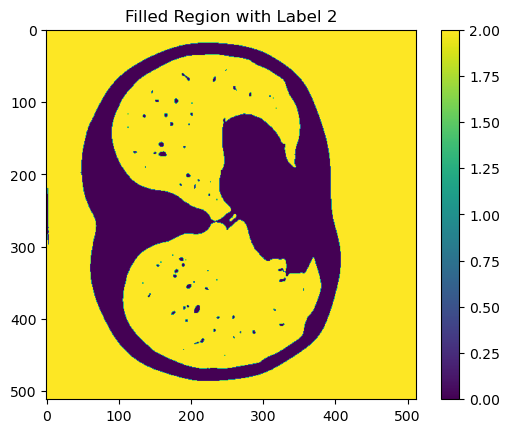

In [15]:
# 肺部区域（标签为2）
lung_data_temp = np.where(clustered_slice_data == 0, 2, clustered_slice_data)

lung_data = np.where(lung_data_temp == 1, 0, lung_data_temp)



# 可视化结果
plt.imshow(lung_data, cmap='viridis')
plt.colorbar()
plt.title('Filled Region with Label 2')
plt.show()


### AND操作筛选肺部区域

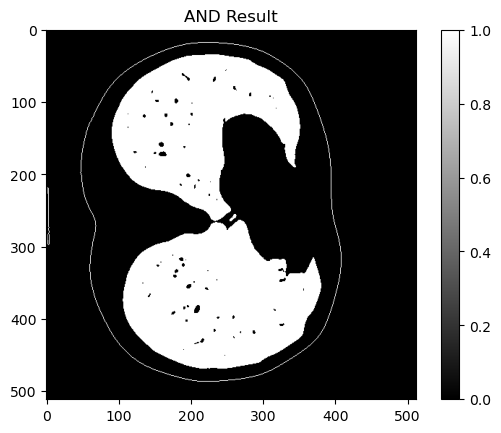

In [16]:
# 异或操作找出在人体区域内的肺部区域
filtered_lung_data = np.logical_and(lung_data, filled_image)

# 可视化结果
plt.imshow(filtered_lung_data, cmap='gray')
plt.colorbar()
plt.title('AND Result')
plt.show()

### 先腐蚀后膨胀操作

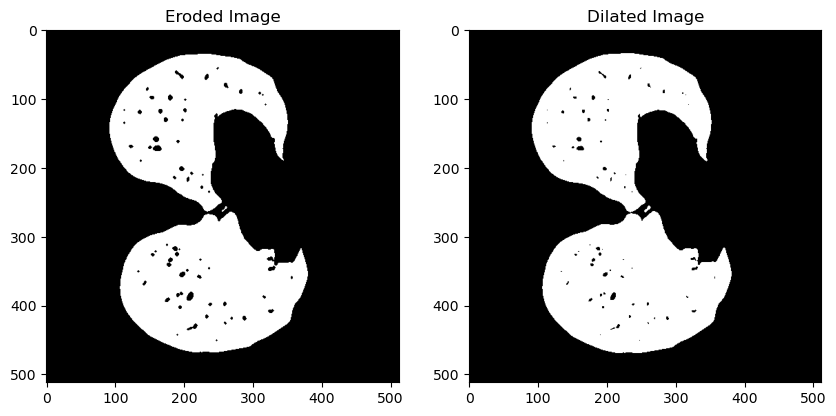

In [17]:
from scipy.ndimage import binary_erosion, binary_dilation


# 腐蚀操作
eroded_image = binary_erosion(filtered_lung_data)

# 膨胀操作
dilated_image = binary_dilation(eroded_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(eroded_image, cmap='gray')
axs[0].set_title('Eroded Image')
axs[1].imshow(dilated_image, cmap='gray')
axs[1].set_title('Dilated Image')
plt.show()

### 填充

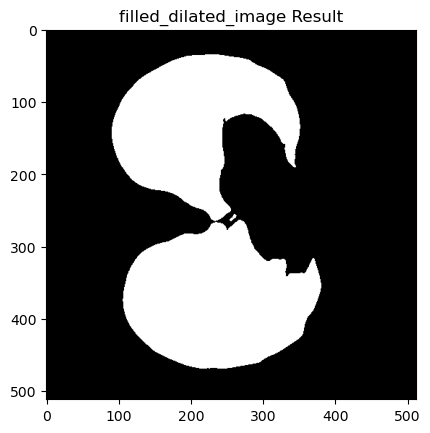

In [18]:
# 将边界内的所有区域填充
filled_dilated_image = binary_fill_holes(dilated_image)

plt.imshow(filled_dilated_image, cmap='gray')
plt.title('filled_dilated_image Result')
plt.show()

### 将Mask应用到原始图像

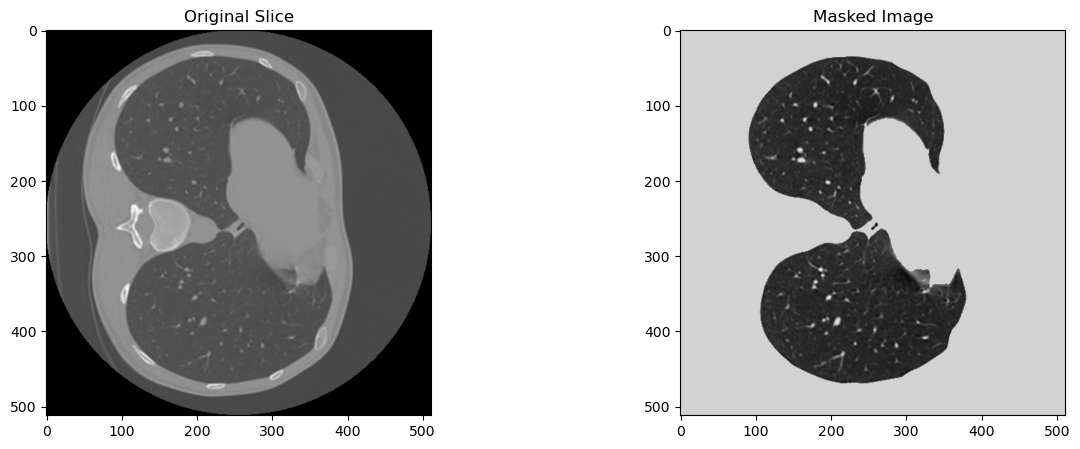

In [19]:
# 应用mask到原始图像
masked_image = np.where(filled_dilated_image, slice_data, 0)

# 可视化结果
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(slice_data, cmap='gray')
axs[0].set_title('Original Slice')

axs[1].imshow(masked_image, cmap='gray')
axs[1].set_title('Masked Image')
plt.show()